In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pmdarima.arima import auto_arima

import statsmodels.graphics.tsaplots as tsg
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0)

df = df_raw[['Date', 'Rainfall_Cavallina', 'Flow_Rate', 'Lake_Level']].copy()

df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

df.set_index(['Date'], inplace=True)
df = df.asfreq('D')
df = df.dropna()
print(df.index)

df.loc[:, 'Lake_Level'] -= (251 - 31)

# df = df.resample('W').mean()
# df = df.asfreq('W')
df.head(5)

DatetimeIndex(['2004-01-01', '2004-01-02', '2004-01-03', '2004-01-04',
               '2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=6026, freq='D')


,Rainfall_Cavallina,Flow_Rate,Lake_Level
Date,,,
2004-01-01,0.0,0.5,31.14
2004-01-02,0.0,0.5,31.21
2004-01-03,0.0,0.5,31.28
2004-01-04,0.0,0.5,31.35
2004-01-05,0.0,0.5,31.37


In [4]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6026 entries, 2004-01-01 to 2020-06-30
Freq: D
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rainfall_Cavallina  6026 non-null   float64
 1   Flow_Rate           6026 non-null   float64
 2   Lake_Level          6026 non-null   float64
dtypes: float64(3)
memory usage: 188.3 KB


,Rainfall_Cavallina,Flow_Rate,Lake_Level
Date,,,
2004-01-01,0.0,0.5,31.14
2004-01-02,0.0,0.5,31.21
2004-01-03,0.0,0.5,31.28
2004-01-04,0.0,0.5,31.35
2004-01-05,0.0,0.5,31.37


<AxesSubplot:xlabel='Date'>

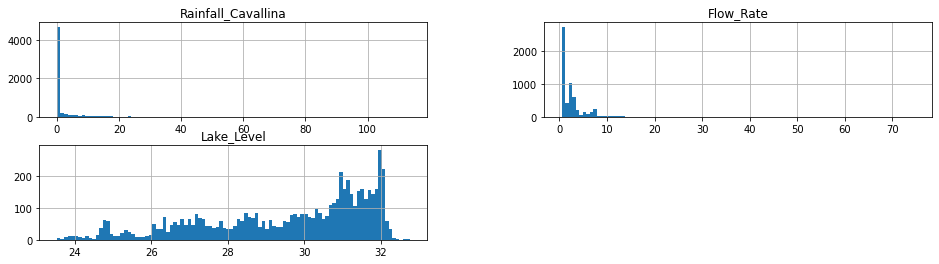

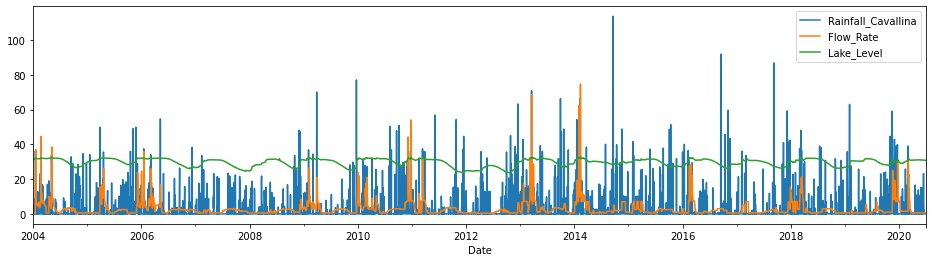

In [5]:
df.hist(figsize=(16, 4), bins=100)
df.plot(figsize=(16, 4))

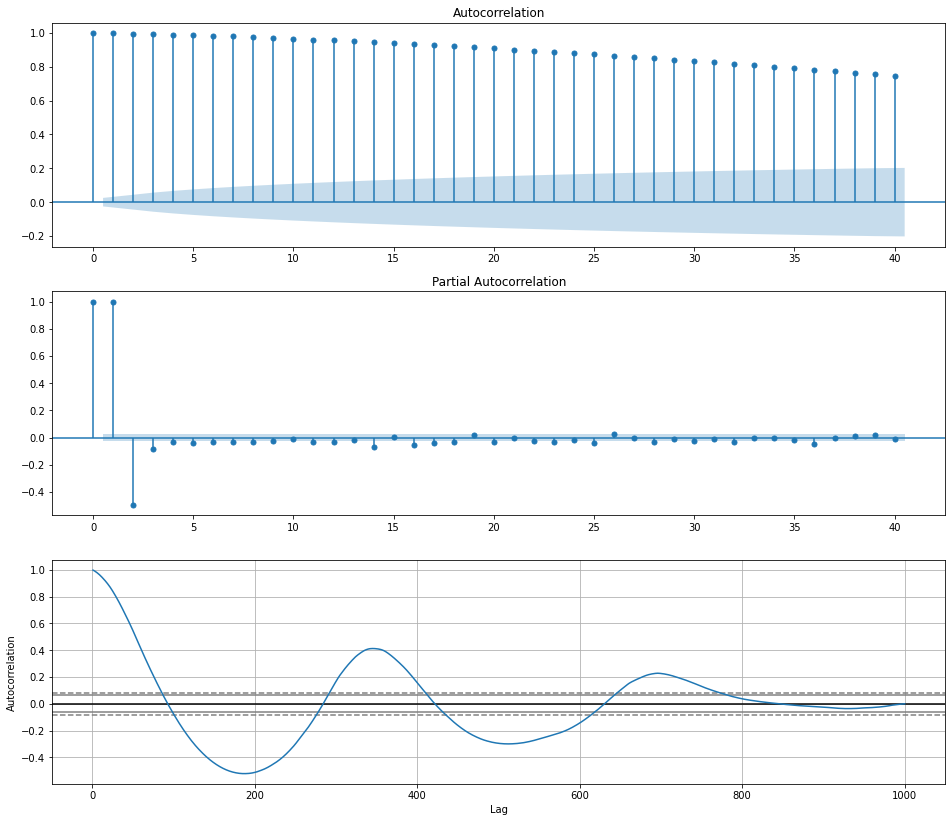

In [6]:
# SEASONALITY CHECK

def seasonality_plot(column):
    fig, ax = plt.subplots(3, 1, figsize=(16, 14))

    tsg.plot_acf(column,lags=40, ax=ax[0])
    tsg.plot_pacf(column,lags=40, ax=ax[1])
    autocorrelation_plot(column[:1000], ax=ax[2])

    plt.show()

seasonality_plot(df['Lake_Level'])

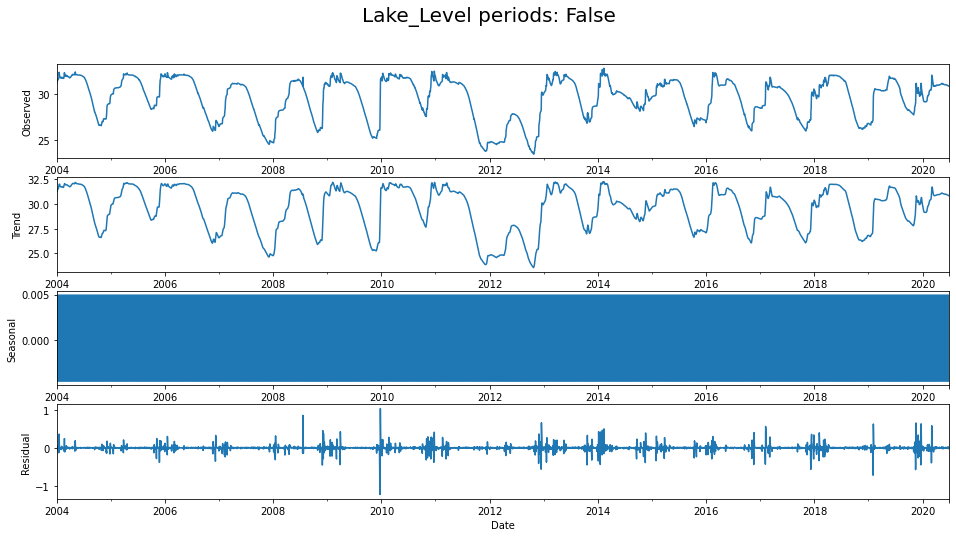

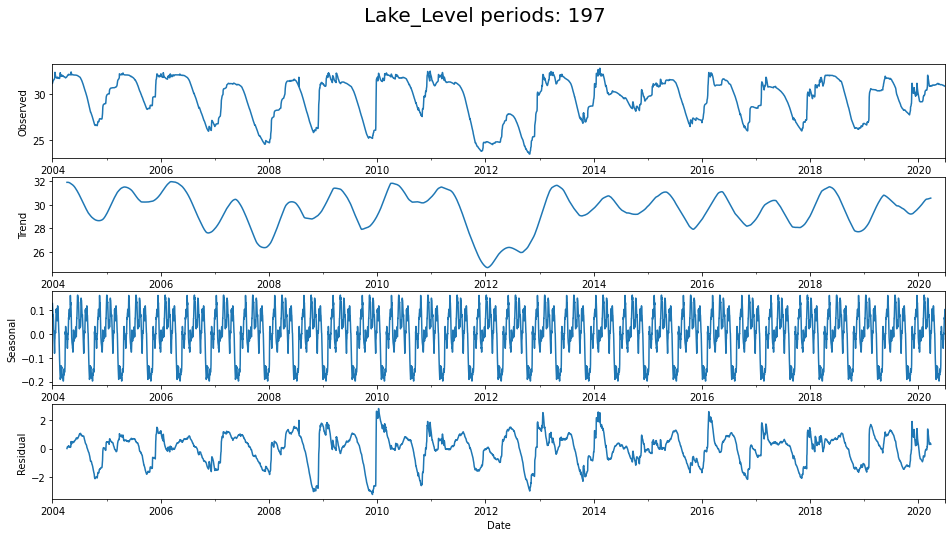

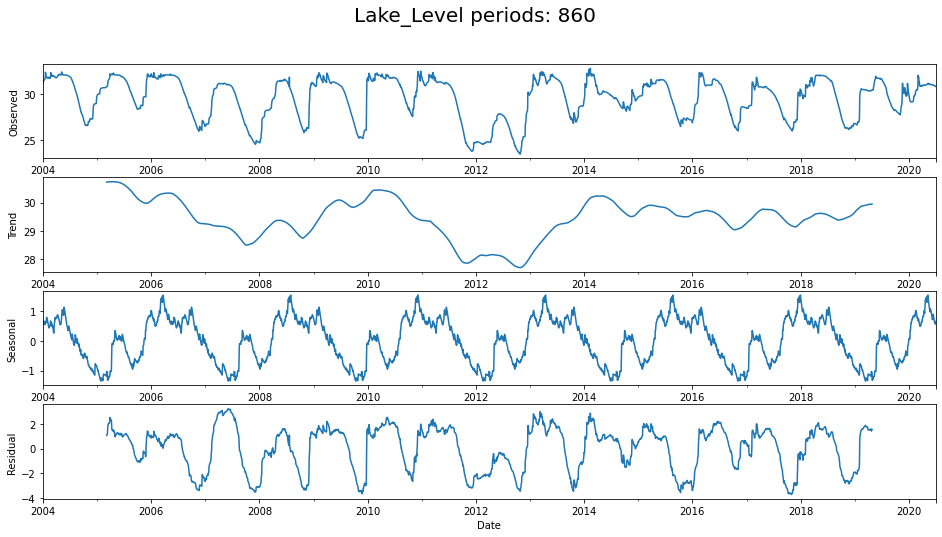

In [7]:
months = int(((max(df.index) - min(df.index)) / np.timedelta64(1, 'M')))
weeks = int(((max(df.index) - min(df.index)) / np.timedelta64(1, 'W')))

def seasonal_decompose_plot(series, period=False):
    
    if period != False:
        result = seasonal_decompose(series, model='additive', period=period)
    else:
        result = seasonal_decompose(series, model='additive', extrapolate_trend='freq')

    fig, ax = plt.subplots(4,1, figsize=(16, 8))
    
    fig.suptitle('{} periods: {}'.format(series.name, period), size=20)

    result.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')
    result.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')
    result.seasonal.plot(ax=ax[2])
    ax[2].set_ylabel('Seasonal')
    result.resid.plot(ax=ax[3])
    ax[3].set_ylabel('Residual')

seasonal_decompose_plot(df['Lake_Level'])
seasonal_decompose_plot(df['Lake_Level'], months)
seasonal_decompose_plot(df['Lake_Level'], weeks)

In [8]:
# STATIONARITY
# Stationarity check means that we have constant mean and variance of the data over the time.
# We can inspect visually or use Dickey-Fuller statistical test.

# Dickey-Fuller statisticall test:
# Is trying to reject the null hypothesis that the data is non-stationary.
# If we reject the test means that data is stationary
#    if p <= 0.05 we reject the null hypothesis and data is stationary
#    if p >  0.05 we accept the null hypothesis and data is non-stationary

def testDickeyFuller(series, rolling_interval, visualise=False):
    adf_test_result = sts.adfuller(series.values)
    
    significance_level = 0.05
    adf = adf_test_result[0]
    pValue = adf_test_result[1]
    threshold_1 = adf_test_result[4]['1%']
    threshold_5 = adf_test_result[4]['5%']
    threshold_10 = adf_test_result[4]['10%']
    
    print('\nDickey-Fuller Test for "{}":'.format(series.name))
    print('\t ADF = {}'.format(str(adf)))
    print('\t   p = {}'.format(str(pValue)))
    
    color = 'purple'
    if (pValue < significance_level) & (adf < threshold_1):
        color = 'forestgreen' 
        print('\tdata IS stationary => p < {} & adf < 1%'.format(significance_level))
    elif (pValue < significance_level) & (adf < threshold_5):
        color = 'orange'
        print('\tdata IS stationary => p < {} & adf < 5%'.format(significance_level))
    elif (pValue < significance_level) & (adf < threshold_10):
        color = 'red'
        print('\tdata IS stationary => p < {} & adf < 10%'.format(significance_level))
    else:
        print('\tdata NOT stationary')
    
    if visualise == True:
        fig, ax = plt.subplots(1, 1, figsize=(16, 6.5))

        fig.suptitle('Time Series: {}'.format(series.name), size=20)

        ax.scatter(x=df.index, y=series, color=color, label=series.name, marker='.', s=10, alpha=1)
        ax2 = ax.twinx()

        ax.plot(series.rolling(rolling_interval).mean(), color='red', label='rolling mean {}'.format(rolling_interval))
        ax.plot(series.rolling(rolling_interval).std(), color='purple', label='rolling std {}'.format(rolling_interval))
        fig.legend()

In [9]:
def make_returns(df, columns):    
    for c in columns:
#         df['{}_ret'.format(c)] = df[c].pct_change(1).mul(100) # can causes 0 / 0 = infinity
        df['{}_ret'.format(c)] = df[c].diff()
    df = df.dropna()
    return df

df = make_returns(df, ['Rainfall_Cavallina', 'Flow_Rate', 'Lake_Level'])

for c in df.columns:
    testDickeyFuller(df[c], months, False)


Dickey-Fuller Test for "Rainfall_Cavallina":
	 ADF = -18.902421000932005
	   p = 0.0
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Flow_Rate":
	 ADF = -10.089478523900356
	   p = 1.1321317252155166e-17
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Lake_Level":
	 ADF = -5.699711266094148
	   p = 7.726366762779989e-07
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Rainfall_Cavallina_ret":
	 ADF = -22.15984685956115
	   p = 0.0
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Flow_Rate_ret":
	 ADF = -18.84433890211933
	   p = 0.0
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Lake_Level_ret":
	 ADF = -11.204606792720012
	   p = 2.2006343703517577e-20
	data IS stationary => p < 0.05 & adf < 1%


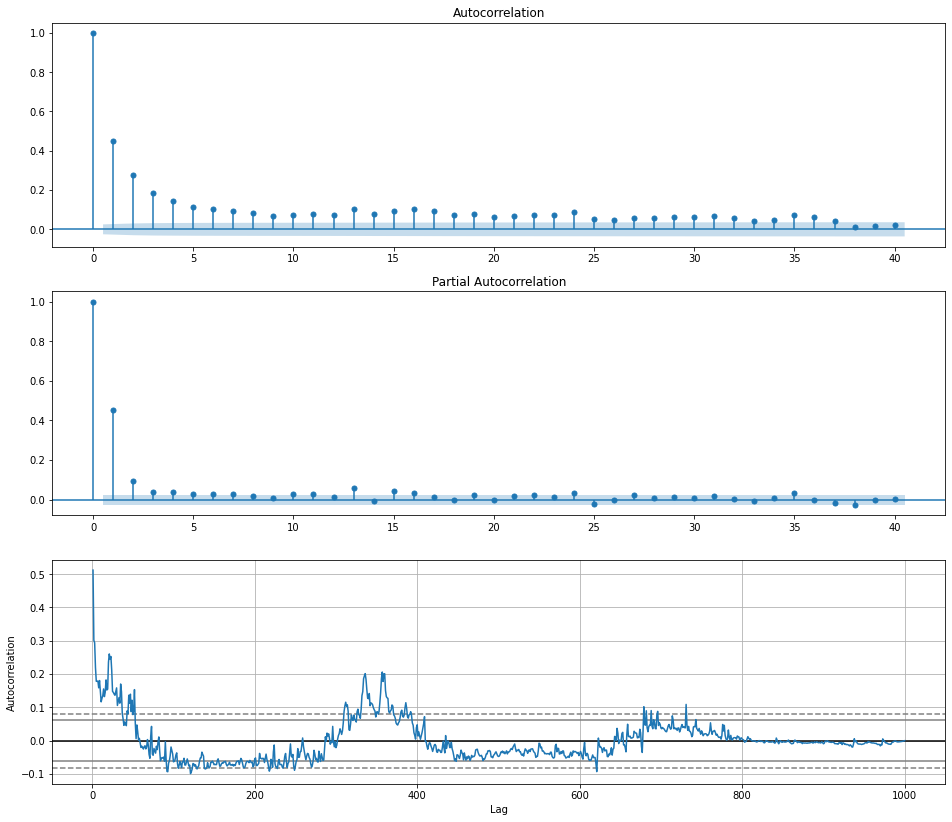

In [10]:
seasonality_plot(df['Lake_Level_ret'])

            Rainfall_Cavallina  Flow_Rate  Lake_Level  Rainfall_Cavallina_ret  \
Date                                                                            
2017-03-09                 0.0        7.0       31.78                     0.0   
2017-03-10                 0.0        7.0       31.77                     0.0   
2017-03-11                 0.0        7.0       31.70                     0.0   
2017-03-12                 0.0        7.0       31.62                     0.0   
2017-03-13                 0.0        7.0       31.54                     0.0   

            Flow_Rate_ret  Lake_Level_ret  
Date                                       
2017-03-09            0.0           -0.01  
2017-03-10            0.0           -0.01  
2017-03-11            0.0           -0.07  
2017-03-12            0.0           -0.08  
2017-03-13            0.0           -0.08  
            Rainfall_Cavallina  Flow_Rate  Lake_Level  Rainfall_Cavallina_ret  \
Date                                       

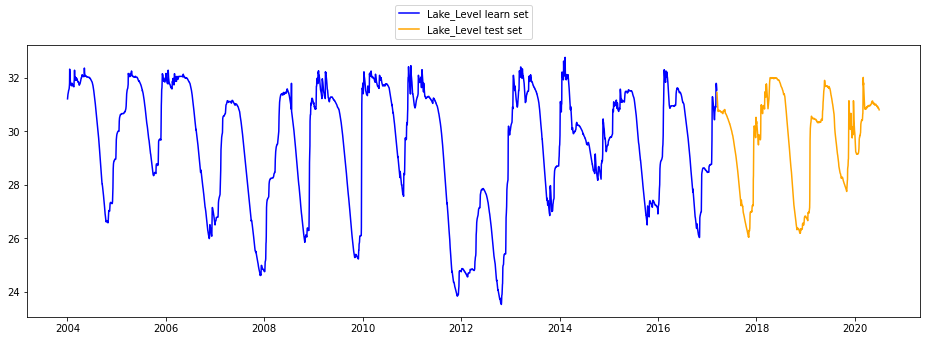

In [11]:
test_percentage = 0.2

split = int(len(df) * (1 - test_percentage))
df_learn = df.iloc[:split]
df_test = df.iloc[split:]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(df_learn['Lake_Level'], color='blue', label='Lake_Level learn set')
ax.plot(df_test['Lake_Level'], color='orange', label='Lake_Level test set')
fig.legend(loc='upper center');

print(df_learn.tail(5))
print(df_test.head(5))

In [12]:
def evaluate_ae(prediction, real_values):
    mae = mean_absolute_error(prediction, real_values)
    rmae = mean_squared_error(prediction, real_values)
    print('   MAE: {}'.format(mae))
    print('   RMAE: {}'.format(rmae))
    return (mae, rmae)

In [13]:
def rolling_forecast(df, test_ratio, interval, fun, printR=False):  
    iterations = range(int(len(df) * (1 - test_ratio)), len(df), interval)
        
    all_forecasts = pd.DataFrame()
        
    for index, split in enumerate(iterations):
        print('Processing iteration: {}/{}'.format(index + 1, len(iterations)), end='\r')        
        
        learn = df[:split]
        test = df[split:split+interval]
        
        fun_res = fun(learn, test, interval)
        
        predictions = pd.DataFrame({
            'Lake_Level': test['Lake_Level'],
            'Prediction': fun_res[0:len(test['Lake_Level'])],
        })        
        all_forecasts = all_forecasts.append(predictions)
        
    mae, rmae = evaluate_ae(all_forecasts['Lake_Level'], all_forecasts['Prediction'])
    
    if printR:
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))
        #ax.plot(learn['Lake_Level'], color='blue', label='Lake_Level')
        ax.plot(all_forecasts['Lake_Level'], color='blue', label='Lake_Level')
        ax.plot(all_forecasts.index, all_forecasts['Prediction'], color='red', label='Prediction')
        fig.legend(loc='upper center');

    return (all_forecasts, mae, rmae)

# SARIMAX

In [14]:
# model_auto = auto_arima(
#     y=df_learn['Lake_Level'],
#     X=df_learn[['Rainfall_Cavallina', 'Flow_Rate']],
#     seasonal=True,
#     stationary=True,
#     alpha=0.05,
#     stepwise=True
# )

# model_auto.summary()

In [15]:
def sarimax(learn, test, interval):
    model = SARIMAX(
        learn['Lake_Level'],
        order=(1, 1, 0),
        season=(0, 0, 0, 0),
        exog = learn[['Rainfall_Cavallina', 'Flow_Rate']],
    )
    model_fit = model.fit()

    predictions = model_fit.predict(
        start=test.index[0].strftime('%Y-%m-%d'),
        end=test.index[-1].strftime('%Y-%m-%d'),
        dynamic=True,
        exog=test[['Rainfall_Cavallina','Flow_Rate']]
    )
    return predictions

   MAE: 1.8149670435896441
   RMAE: 5.916524278438942


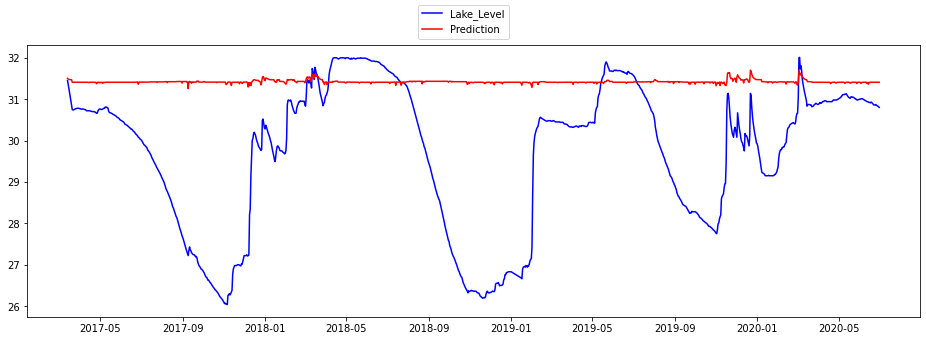

In [16]:
rolling_forecast(df, test_percentage, len(df_test), sarimax, True);

   MAE: 0.09752013334908999
   RMAE: 0.10004244746331088


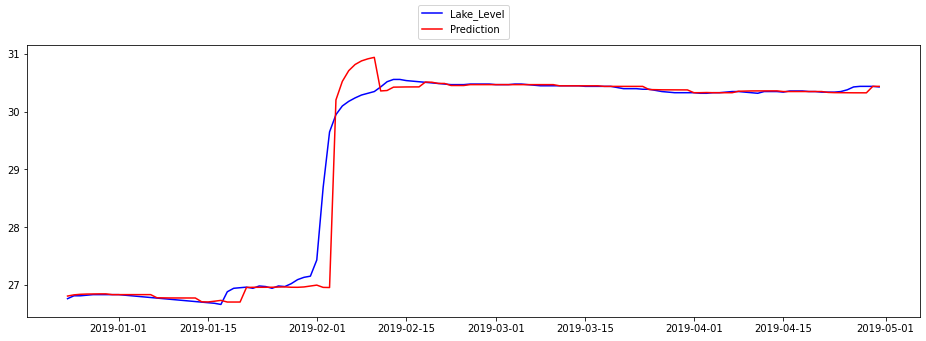

In [17]:
rolling_forecast(
df[
    (df.index > pd.to_datetime('2017-08-01')) &
    (df.index < pd.to_datetime('2019-05-01'))
], test_percentage, 7, sarimax, True);

   MAE: 0.1207177705105504573
   RMAE: 0.06079391237398588


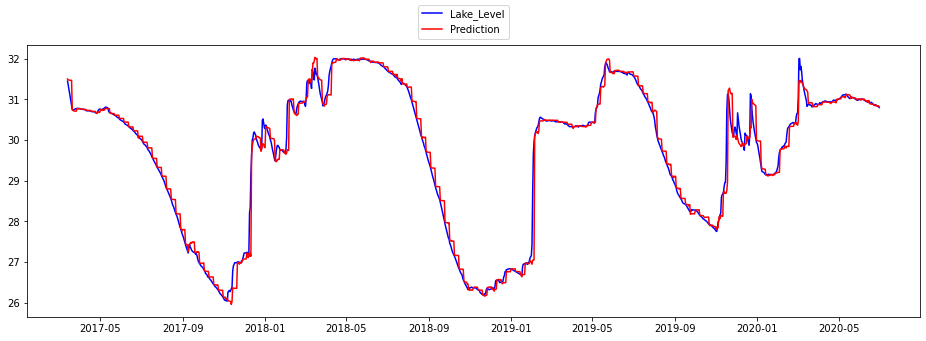

In [18]:
rolling_forecast(df, test_percentage, 7, sarimax, True);

# Facebook Prophet

In [19]:
pm = None

def stan_init(m):
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

def fb_prophet(learn, test, interval):
        
    learn = pd.DataFrame({ 'ds': learn.index, 'y': learn['Lake_Level']  })
    test = pd.DataFrame({ 'ds': test.index, 'y': test['Lake_Level'] })
    
    global pm # <= bad practice
    p = Prophet(daily_seasonality=False)
    if pm == None:
        pm = p.fit(learn)
    else:
        pm = p.fit(learn, init=stan_init(pm))

    future = pm.make_future_dataframe(periods=len(test))
    forecast = pm.predict(future).tail(len(test))
          
    return forecast['yhat'].to_numpy()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


   MAE: 0.8811705892050238
   RMAE: 1.2461558150874041


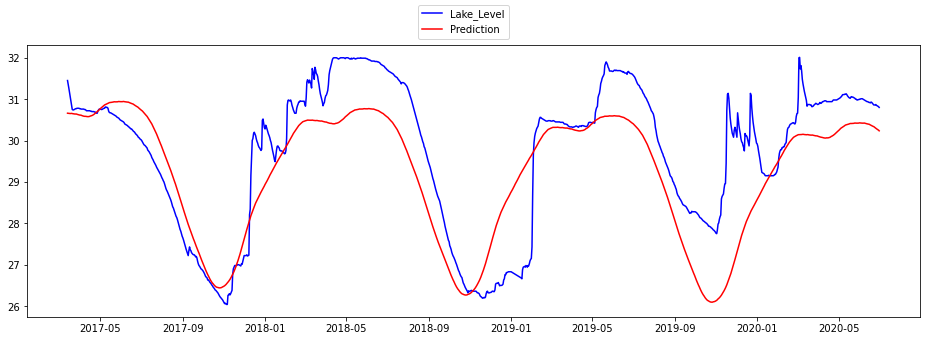

In [20]:
pm=None
rolling_forecast(df, test_percentage, len(df_test), fb_prophet, True);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


   MAE: 1.14402597884251849
   RMAE: 1.9384042622211806


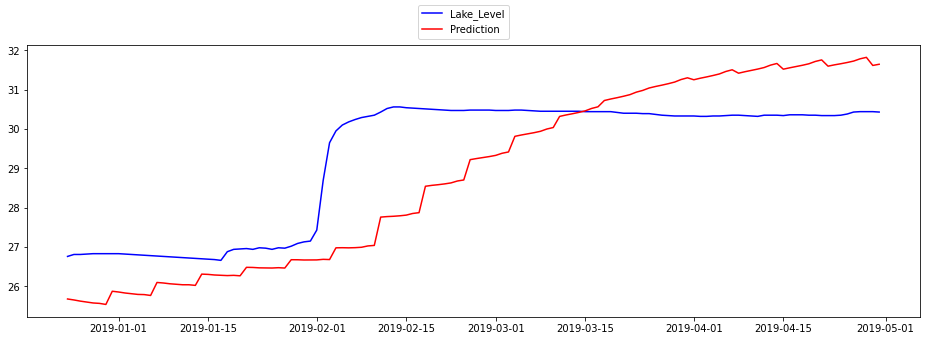

In [21]:
pm=None
rolling_forecast(
df[
    (df.index > pd.to_datetime('2017-08-01')) &
    (df.index < pd.to_datetime('2019-05-01'))
], test_percentage, 7, fb_prophet, True);